In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from pathlib import Path
from analysis import collection, analysis
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

In [3]:
collection_name = "emg_olympics"
subject_names = collection.get_subject_names(collection_name)
print(f"{len(subject_names)} subjects in {collection_name}.")
c = collection.Collection(collection_name)

46 subjects in emg_olympics.


## Plot average learning measures over blocks

## Fit log curves and plot learning rates

### Find top, median, and lowest hit subjects

In [4]:
# count the number of hits over all sessions for each subject in the collection
hit_counts = {}
for name, sub in c.subjects.items():
    t = sub.tasks["center_hold"]
    sessions = t.sorted_sessions()
    hit_counts[name] = [s.outcome_counts for s in sessions]

In [5]:
# count total number of hits per subject

hit_sums = {}
for subject_name in hit_counts.keys():
    hit_sums[subject_name] = sum([sesh["hits"] for sesh in hit_counts[subject_name]])

sorted_hit_sums = sorted(hit_sums.items(), key = lambda e: e[1])

most_hit_subject = sorted_hit_sums[-1][0]
most_hits = sorted_hit_sums[-1][1]

least_hit_subject = sorted_hit_sums[0][0]
least_hits = sorted_hit_sums[0][1]

median_hit_subject = sorted_hit_sums[len(sorted_hit_sums)//2][0]
median_hits = sorted_hit_sums[len(sorted_hit_sums)//2][1]

print(most_hit_subject, "hits: ", most_hits)
print(median_hit_subject, "hits: ", median_hits)
print(least_hit_subject, "hits: ", least_hits)

# morio 524
# holly 412
# hyewon 212

morio hits:  524
holly hits:  412
hyewon hits:  212


### plot hits and no-holds over sessions

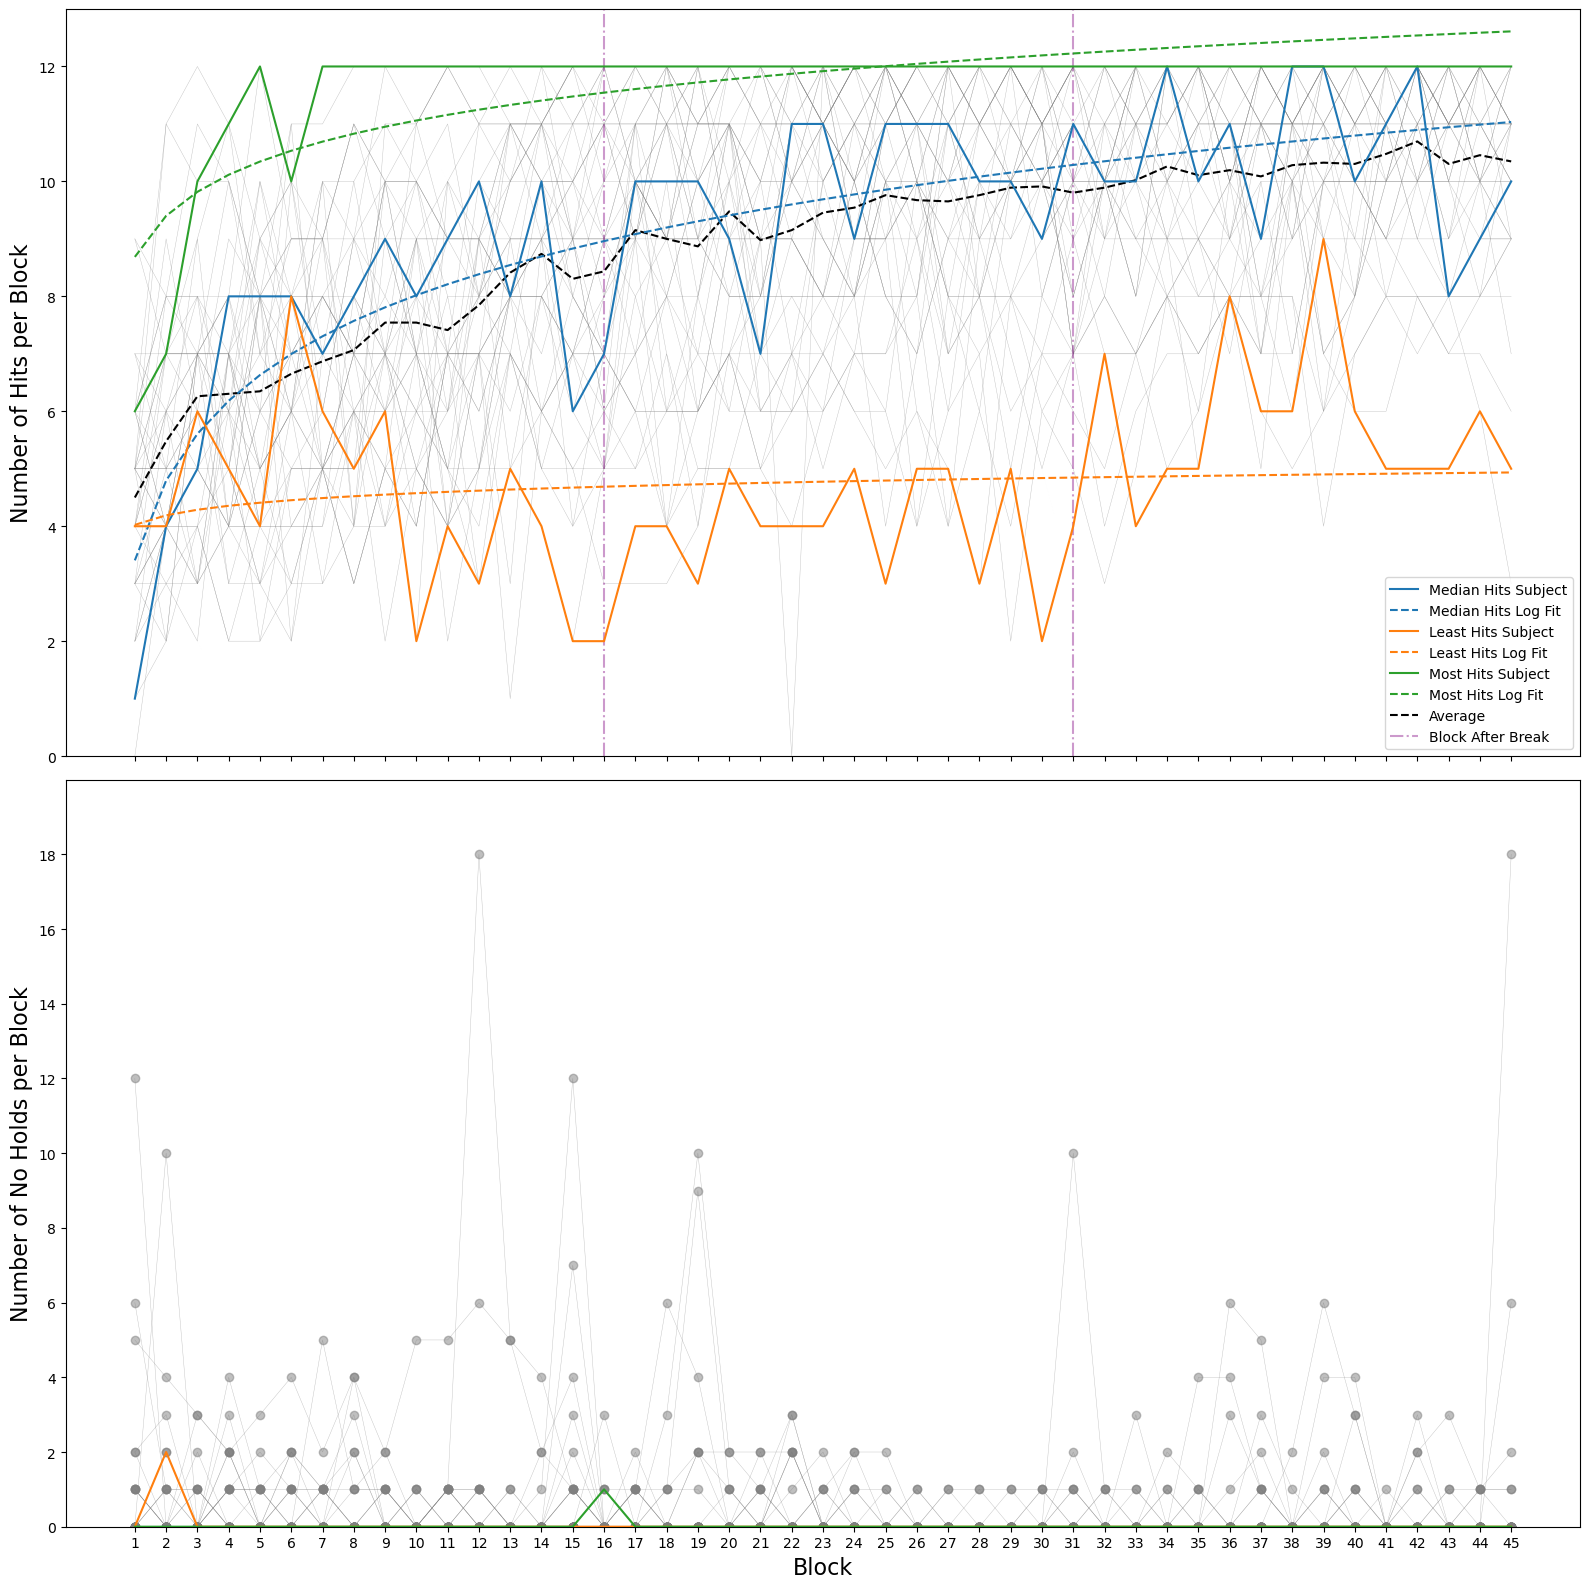

In [6]:
outcomes_fig, (hit_ax, nohold_ax) = plt.subplots(2,1,figsize=(16,16),sharex=True)
hit_sum = np.zeros((45))
hit_learning_rates = {}
for sub in hit_counts.keys():
    hit_vec = np.array([h["hits"] for h in hit_counts[sub]][:45])
    no_hold_vec = np.array([h["noholds"] for h in hit_counts[sub]][:45])
    hit_sum = np.add(hit_sum, hit_vec)
    x = np.arange(1,len(hit_vec) + 1)
    params = curve_fit(analysis.log, x, hit_vec)[0]
    hit_learning_rates[sub] = params[1]
    if sub == most_hit_subject:
        hit_ax.plot(hit_vec,label="Most Hits Subject", zorder=100)
        # shifting the fit over by 1 block -- this seems illegal?
        hit_ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:green", zorder=100, label="Most Hits Log Fit")
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45],zorder=100)
        nohold_ax.plot(no_hold_vec,zorder=100)
    elif sub == median_hit_subject:
        hit_ax.plot(hit_vec,label="Median Hits Subject",zorder=100)
        hit_ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:blue", zorder=100, label="Median Hits Log Fit")
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45],zorder=100)
        nohold_ax.plot(no_hold_vec,zorder=100)
    elif sub == least_hit_subject:
        hit_ax.plot(hit_vec,label="Least Hits Subject",zorder=100)
        hit_ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:orange", zorder=100, label="Least Hits Log Fit")
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45],zorder=100)
        nohold_ax.plot(no_hold_vec,zorder=100)
    else:
        hit_ax.plot(hit_vec, "grey", linewidth=0.3,alpha=0.5)
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)
        nohold_ax.plot(no_hold_vec, "-o", c="grey", linewidth=0.3,alpha=0.5)

# average hits over subjects
hit_avg = np.divide(hit_sum, len(hit_counts.keys()))
hit_ax.plot(hit_avg, "k--", label="Average")

# hit_ax.set_title("Hits over Blocks", fontsize=16)
hit_ax.set_ylim([0,13])
hit_ax.set_ylabel("Number of Hits per Block", fontsize=16)
# add lines for subjects taking a rest
hit_ax.plot([15, 15], hit_ax.get_ylim(), "-.", c="purple", alpha=0.4, label="Block After Break")
hit_ax.plot([30, 30], hit_ax.get_ylim(), "-.", c="purple", alpha=0.4)
hit_ax.legend(loc="lower right")

# miss_ax.set_title("Misses over Blocks", fontsize=16)
# miss_ax.set_ylim([0,105])
# miss_ax.set_ylabel("Miss Percentage [%]", fontsize=16)

# nohold_ax.set_title("No Holds over Blocks", fontsize=16)
nohold_ax.set_ylabel("Number of No Holds per Block", fontsize=16)
nohold_ax.set_ylim([0,20])
nohold_ax.set_yticks(list(range(0,20,2)))
nohold_ax.set_xlabel("Block", fontsize=16)
nohold_ax.set_xticks(list(range(45)))
nohold_ax.set_xticklabels(list(range(1,46)))

outcomes_fig.tight_layout()

In [7]:
outcomes_fig.savefig(image_path / "analysis/hits_and_noholds_over_blocks.pdf", dpi=300, format="pdf")

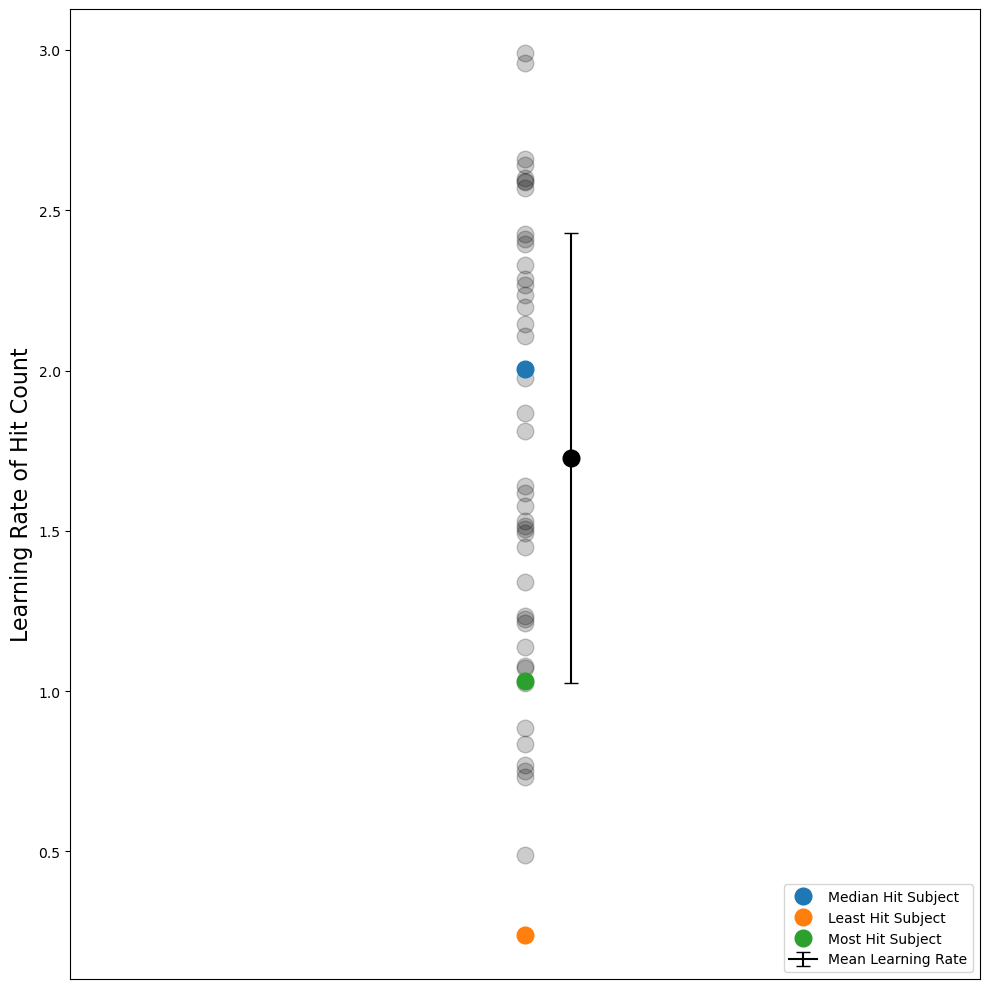

In [8]:
hit_learning_rate_fig, ax = plt.subplots(1,1,figsize=(10,10))

for name, lr in list(hit_learning_rates.items()):
    if name == most_hit_subject:
        ax.plot(0, lr, "o", c='tab:green', zorder=100, label="Most Hit Subject", markersize=12)
    elif name == median_hit_subject:
        ax.plot(0, lr, "o", c='tab:blue', zorder=100, label="Median Hit Subject", markersize=12)
    elif name == least_hit_subject:
        ax.plot(0, lr, "o", c='tab:orange', zorder=100, label="Least Hit Subject", markersize=12)
    else:
        ax.plot(0,lr,'ko',alpha=0.2, markersize=12)
ax.set_ylabel("Learning Rate of Hit Count", fontsize=16)
ax.set_xticks([])

lr_list = list(hit_learning_rates.values())
ax.plot(0.1, np.mean(lr_list), "ko", markersize=12)
ax.errorbar(0.1, np.mean(lr_list), yerr=np.std(lr_list), markersize=12, c="k", capsize=5, label="Mean Learning Rate")
# ax.plot(0.1, np.median(lr_list), "*k", markersize=10, label="Median Learning Rate")
ax.set_xlim([-1,1])
ax.legend(loc="lower right")

hit_learning_rate_fig.tight_layout()


In [9]:
hit_learning_rate_fig.savefig(image_path / "analysis/hits_learning_rates.pdf", dpi=300, format="pdf")

## plot and fit the hit reach times

In [10]:
def avg(l):
    if len(l) == 0:
        return None
    else:
        return sum(l)/len(l)

def drop_nones(l, return_indices=False):
    new_l = []
    enum = []
    for i, e in enumerate(l):
        if not e is None:
            new_l.append(e)
            enum.append(i)
    if return_indices:
        return enum, new_l
    else:
        return new_l

def nones_to_zeros(l):
    xa = np.array(l)
    xa[xa == None] = 0
    return xa.astype(list)


In [11]:
# average "Hit" reach time per session over subjects
avg_reach_times = {}
for sub in c.subjects.values():
    avg_reach_times[sub.name] = []
    for session in sorted(list(sub.tasks["center_hold"].sessions.values()),key=lambda s: s.number):
        sorted_trials = sorted(list(session.trials.values()), key=lambda d: d.number)
        # mean hit reach time over trials in a session
        avg_reach_times[sub.name].append(avg([t.reach_time for t in sorted_trials if t.outcome == "Hit"]))

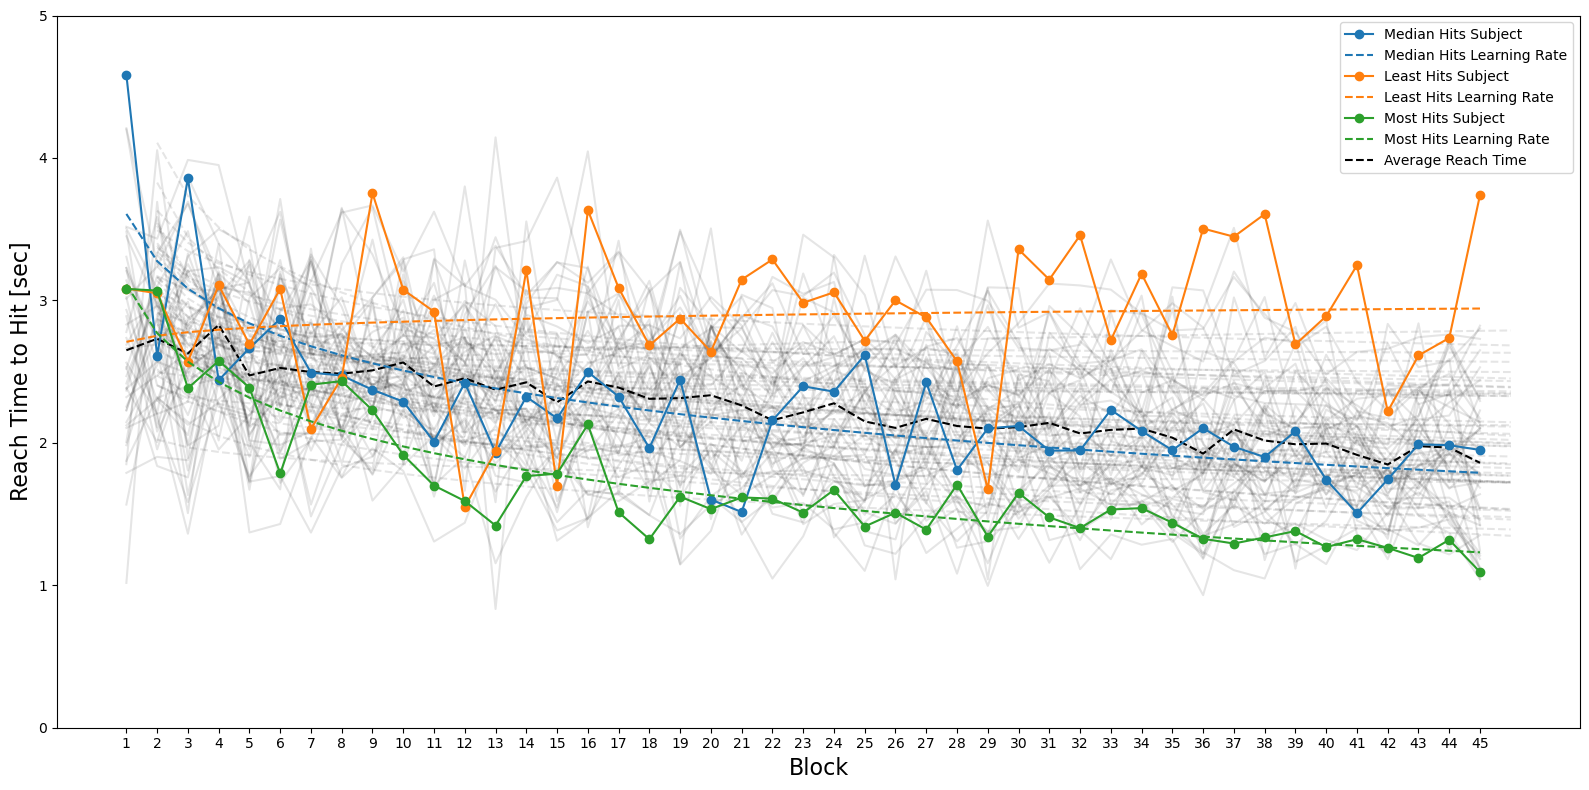

In [12]:
reach_time_learning_rates = {}
reach_time_sum = np.zeros((45))

fig, ax = plt.subplots(1,1, figsize=[16,8])
for s in c.subjects.values():
    
    rt = avg_reach_times[s.name]
    reach_time_vec = nones_to_zeros(rt)
    reach_time_sum = np.add(reach_time_sum, reach_time_vec)

    x, y = drop_nones(rt, return_indices=True)
    x = [xx+1 for xx in x]
    params = curve_fit(analysis.log, x, y)[0]
    reach_time_learning_rates[s.name] = params[1]
    if s.name == most_hit_subject:
        ax.plot(rt,'-o', c="tab:green", zorder=100, label="Most Hits Subject")
        ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:green", zorder=100, label="Most Hits Learning Rate")
    elif s.name == median_hit_subject:
        ax.plot(rt,'-o', c="tab:blue", zorder=100, label="Median Hits Subject")
        ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:blue", zorder=100, label="Median Hits Learning Rate")
    elif s.name == least_hit_subject:
        ax.plot(rt,'-o', c="tab:orange",zorder=100, label="Least Hits Subject")
        ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:orange",zorder=100, label="Least Hits Learning Rate")
    else:
        ax.plot(rt,'k', alpha=0.1)
        ax.plot(x, analysis.log(x, params[0], params[1]), "--", c='k', alpha=0.1)

# average over subjects
reach_time_avg = np.divide(reach_time_sum, len(c.subjects.keys()))
ax.plot(reach_time_avg, "k--", label="Average Reach Time")

ax.set_ylim([0,5])
ax.set_ylabel("Reach Time to Hit [sec]", fontsize=16)
ax.set_xlabel("Block", fontsize=16)
ax.set_xticks(list(range(45)))
ax.set_xticklabels(list(range(1,46)))
ax.legend(loc="upper right")

fig.tight_layout()

In [13]:
fig.savefig(image_path / "analysis/reach_times_over_blocks.pdf", dpi=300, format="pdf")

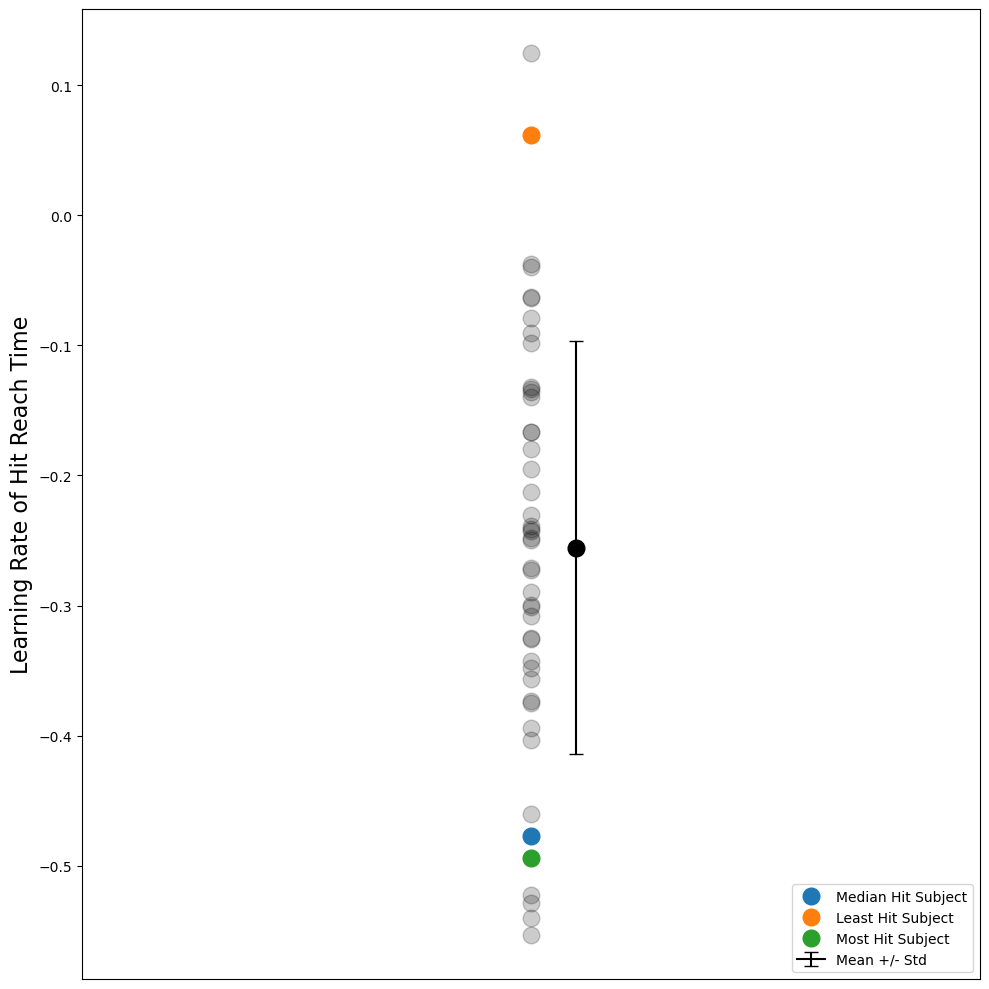

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for name, lr in list(reach_time_learning_rates.items()):
    if name == most_hit_subject:
        ax.plot(0, lr, "o", c='tab:green', zorder=100, label="Most Hit Subject", markersize=12)
    elif name == median_hit_subject:
        ax.plot(0, lr, "o", c='tab:blue', zorder=100, label="Median Hit Subject", markersize=12)
    elif name == least_hit_subject:
        ax.plot(0, lr, "o", c='tab:orange', zorder=100, label="Least Hit Subject", markersize=12)
    else:
        ax.plot(0,lr,'ko',alpha=0.2, markersize=12)
ax.set_ylabel("Learning Rate of Hit Reach Time", fontsize=16)
ax.set_xticks([])

lr_list = list(reach_time_learning_rates.values())
ax.plot(0.1, np.mean(lr_list), "ko", markersize=12)
ax.errorbar(0.1, np.mean(lr_list), yerr=np.std(lr_list), markersize=12, c="k", capsize=5, label="Mean +/- Std")
# ax.plot(0.1, np.median(lr_list), "k*", markersize=10, label="Median Learning Rate")
ax.set_xlim([-1,1])
ax.legend(loc="lower right")

fig.tight_layout()

In [15]:
fig.savefig(image_path / "analysis/reach_time_learning_rates.pdf", dpi=300, format="pdf")

# mean trajectory path length over blocks

In [16]:
def path_length(a):
    assert a.shape[0] > a.shape[1], f"array with shape {a.shape} should be transposed."
    assert a.shape[1] == 2, f"array with shape {a.shape} must be two-dimensional"
    return np.sum(np.sqrt(np.sum(np.diff(a, axis=0)**2,axis=1)))

In [17]:
sample_rate = 200 # samples / sec
reaction_time_delay = 25 # samples == 25 samples / 200Hz = 125ms 

avg_path_lengths = {}
for sub in c.subjects.values():
    avg_path_lengths[sub.name] = []
    # for each session
    for session in sorted(list(sub.tasks["center_hold"].sessions.values()),key=lambda s: s.number):
        sorted_trials = sorted(list(session.trials.values()), key=lambda d: d.number)
        curr_block_lengths = []
        for t in sorted_trials:
            # only look at Hit trials
            if t.outcome == "Hit":
                traj = t.get_trajectory()
                # path length of movement time / reach time -- basically average velocity
                movement_portion = traj[(int(np.ceil(t.hold_time*sample_rate))):,-2:]
                # not sure what's going on here?
                if movement_portion.shape[0] == 0:
                    print(sub.name, session.name, t.name, traj.shape, movement_portion.shape, int(np.ceil(t.hold_time*sample_rate)))
                    continue
                curr_block_lengths.append(path_length(movement_portion))
        # sometimes there are no Hits! meaning no path lengths here
        if len(curr_block_lengths) == 0:
            avg_path_lengths[sub.name].append(None)
        else:
            # average of the hit path lengths for this block
            avg_path_lengths[sub.name].append(np.mean(curr_block_lengths))


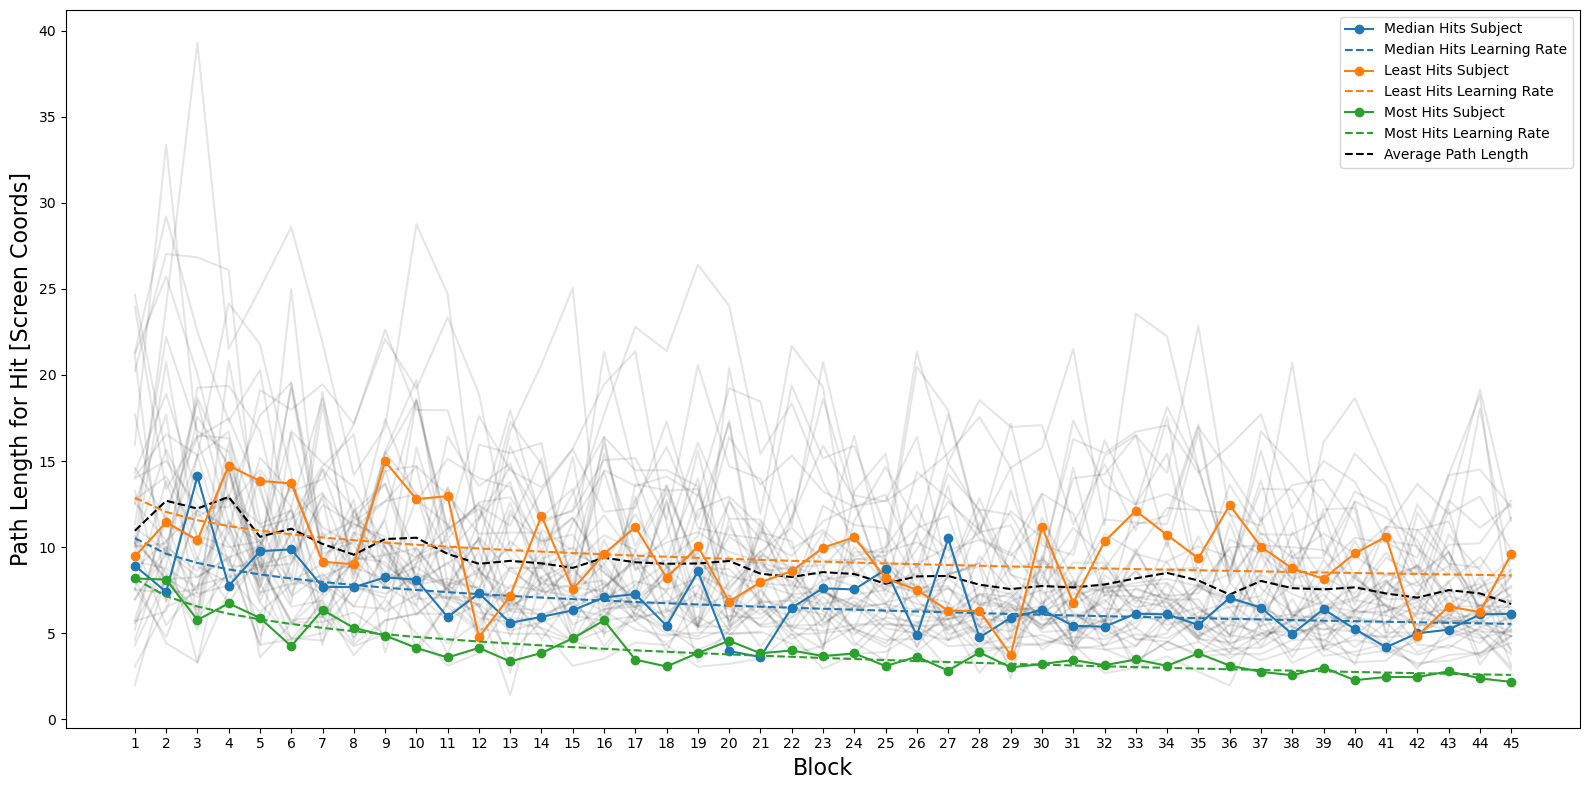

In [18]:
path_length_learning_rates = {}
pl_sum = np.zeros((45))

fig, ax = plt.subplots(1,1, figsize=[16,8])
for s in c.subjects.values():
    l = avg_path_lengths[s.name]

    pl_vec = nones_to_zeros(l)
    pl_sum = np.add(pl_sum, pl_vec)

    x, y = drop_nones(l, return_indices=True)
    x = [xx+1 for xx in x]
    if True in np.isnan(y):
        print(s.name)
    params = curve_fit(analysis.log, x, y)[0]
    path_length_learning_rates[s.name] = params[1]
    if s.name == most_hit_subject:
        ax.plot(l,'-o', c="tab:green", zorder=100, label="Most Hits Subject")
        ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:green", zorder=100, label="Most Hits Learning Rate")
    elif s.name == median_hit_subject:
        ax.plot(l,'-o', c="tab:blue", zorder=100, label="Median Hits Subject")
        ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:blue", zorder=100, label="Median Hits Learning Rate")
    elif s.name == least_hit_subject:
        ax.plot(l,'-o', c="tab:orange",zorder=100, label="Least Hits Subject")
        ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:orange",zorder=100, label="Least Hits Learning Rate")
    else:
        ax.plot(l,'k', alpha=0.1)


pl_avg = np.divide(pl_sum, len(c.subjects.keys()))
ax.plot(pl_avg, "k--", label="Average Path Length")

# targets are placed around the unit circle
ax.set_ylabel("Path Length for Hit [Screen Coords]", fontsize=16)
ax.set_xlabel("Block", fontsize=16)
ax.set_xticks(list(range(45)))
ax.set_xticklabels(list(range(1,46)))
ax.legend(loc="upper right")

fig.tight_layout()

In [19]:
fig.savefig(image_path / "analysis/path_length_over_blocks.pdf", dpi=300, format="pdf")

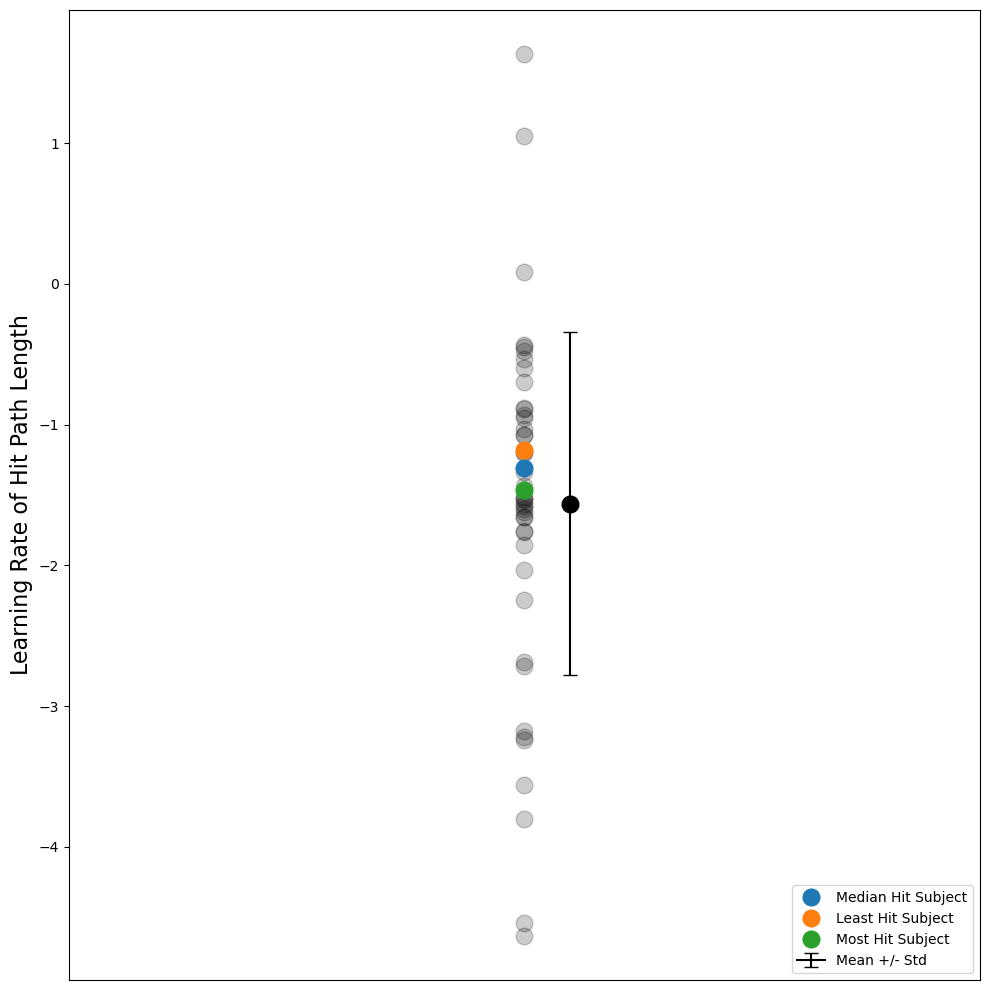

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for name, lr in list(path_length_learning_rates.items()):
    if name == most_hit_subject:
        ax.plot(0, lr, "o", c='tab:green', zorder=100, label="Most Hit Subject", markersize=12)
    elif name == median_hit_subject:
        ax.plot(0, lr, "o", c='tab:blue', zorder=100, label="Median Hit Subject", markersize=12)
    elif name == least_hit_subject:
        ax.plot(0, lr, "o", c='tab:orange', zorder=100, label="Least Hit Subject", markersize=12)
    else:
        ax.plot(0,lr,'ko',alpha=0.2, markersize=12)
ax.set_ylabel("Learning Rate of Hit Path Length", fontsize=16)
ax.set_xticks([])

lr_list = list(path_length_learning_rates.values())
ax.plot(0.1, np.mean(lr_list), "ko", markersize=12)
ax.errorbar(0.1, np.mean(lr_list), yerr=np.std(lr_list), markersize=12, c="k", capsize=5, label="Mean +/- Std")
# ax.plot(0.1, np.median(lr_list), "*k", markersize=10, label="Median Learning Rate")
ax.set_xlim([-1,1])
ax.legend(loc="lower right")

fig.tight_layout()

In [21]:
fig.savefig(image_path / "analysis/path_length_learning_rates.pdf", dpi=300, format="pdf")

## trajectory segments over blocks

In [22]:
def get_zero_crossings(x):
    # find the indices where the velocity of the trajectory changes sign
    assert len(x.shape) == 1
    return np.where(np.diff(np.sign(np.diff(x))))[0]

def get_segment_indices(t, hold_steps, velocity_threshold_percentage=6, min_crossing_interval=8):
    assert t.shape[1] == 2, f"trajectory has incorrect shape: {t.shape}"
    zero_crosses_x = get_zero_crossings(t[:,0])
    zero_crosses_y = get_zero_crossings(t[:,1])
    # combine vx and vy together
    zero_crosses_xy = np.concatenate((zero_crosses_x, zero_crosses_y))
    # sort the x and y indices
    zero_crosses_xy.sort()
    zc_clean = []
    vel_lim = np.max(np.abs(t))*(velocity_threshold_percentage/100)
    for i, z in enumerate(zero_crosses_xy[:-1]):
        # ignore anything before hold period
        if z > hold_steps:
            # reject crossing if the neighborhood is low velocity
            if np.max(np.abs(t[z-min([5,z]):z+5, :])) > vel_lim:
                # reject the crossing if it's not spaced out above a threshold
                if abs(z - zero_crosses_xy[i+1]) > min_crossing_interval: 
                    zc_clean.append(z)
    return zc_clean

def sorted_dict_items_by_key(d):
    return [(k, v) for k, v in sorted(d.items(), key= lambda b: b[0])]

In [23]:
reaction_time_delay = 50 # 200 ms?
sample_rate = 200

# hold_time is the time until the target appears (subjects have thus held for 0.75s within a possible 3.5s window)
avg_segments = {}
# get sorted subjects
for sub in c.alphabetically_sorted_subjects():
    avg_segments[sub.name] = []
    for session in sub.tasks["center_hold"].sorted_sessions():
        segment_counts_per_session = []
        for trial in session.sorted_trials():
            # ignore no hold trials
            if trial.outcome == "Hit":
                trial.get_trajectory()
                trajectory = trial.trajectory[:,-2:]
                # time at beginning of trial for holding
                hold_steps = int(np.ceil(trial.hold_time*sample_rate)) + reaction_time_delay
                # find segments
                segment_indices = get_segment_indices(trajectory, hold_steps=hold_steps)
                # count segments
                segment_counts_per_session.append(len(segment_indices))
            # elif trial.outcome == "Miss":
            #     segment_counts_per_session.append(None)
        # mean over only the hit trials!
        if len(segment_counts_per_session) == 0:
            avg_segments[sub.name].append(None)    
        else:
            avg_segments[sub.name].append(np.mean(drop_nones(segment_counts_per_session)))

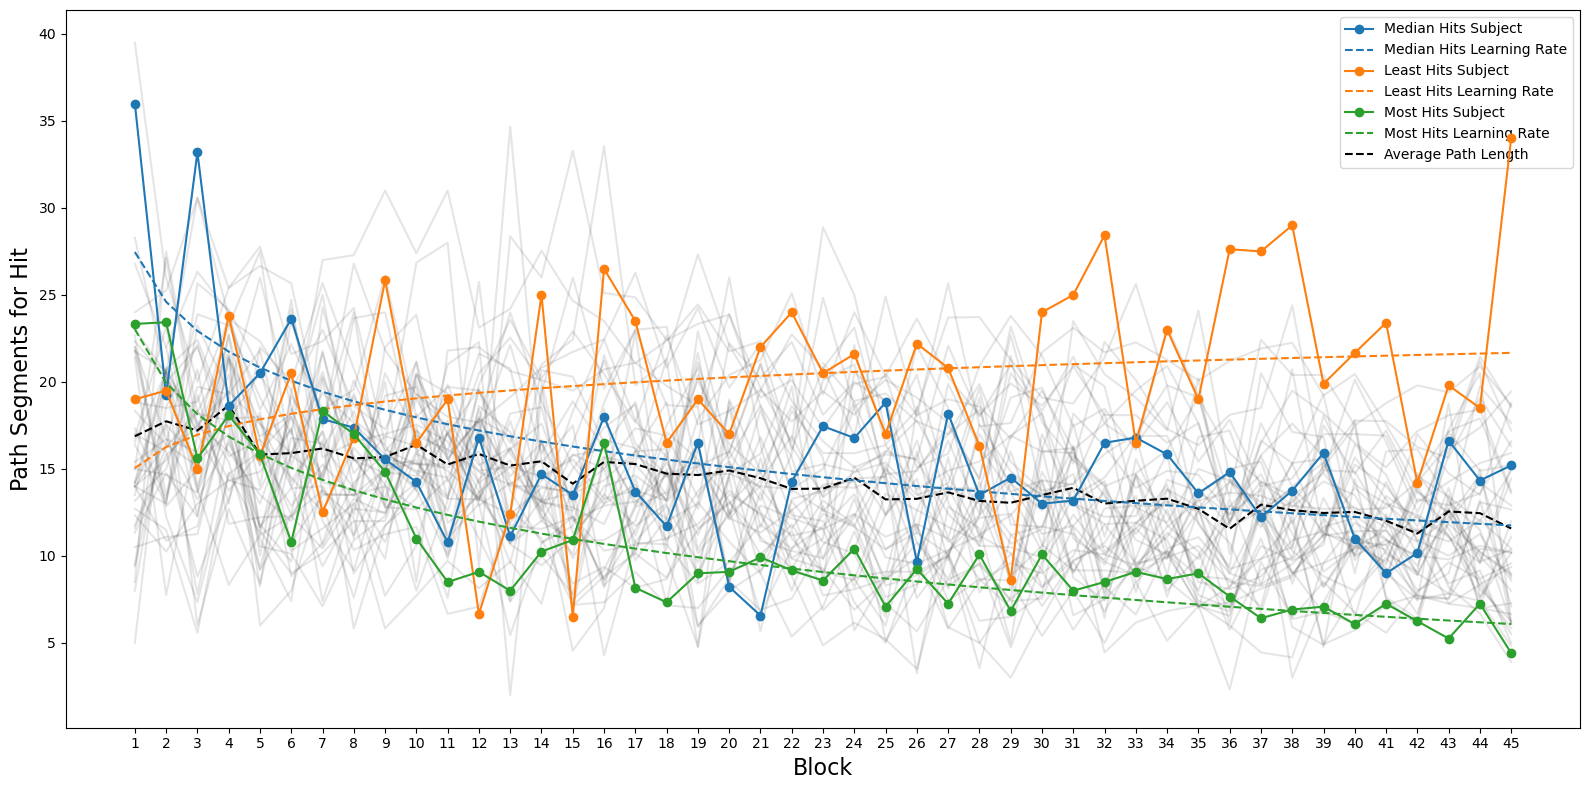

In [24]:
segment_fig, segment_ax = plt.subplots(1,1, figsize=(16,8))

segment_learning_rates = {}
segment_sum = np.zeros((45))

for s in c.subjects.values():
    segs = avg_segments[s.name]

    segment_vec = nones_to_zeros(segs)
    segment_sum = np.add(segment_sum, segment_vec)

    x, y = drop_nones(segs, return_indices=True)
    x = [xx+1 for xx in x]
    if True in np.isnan(y):
        print(s.name)
    params = curve_fit(analysis.log, x, y)[0]
    segment_learning_rates[s.name] = params[1]
    if s.name == most_hit_subject:
        segment_ax.plot(segs,'-o', c="tab:green", zorder=100, label="Most Hits Subject")
        segment_ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:green", zorder=100, label="Most Hits Learning Rate")
    elif s.name == median_hit_subject:
        segment_ax.plot(segs,'-o', c="tab:blue", zorder=100, label="Median Hits Subject")
        segment_ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:blue", zorder=100, label="Median Hits Learning Rate")
    elif s.name == least_hit_subject:
        segment_ax.plot(segs,'-o', c="tab:orange",zorder=100, label="Least Hits Subject")
        segment_ax.plot([xx-1 for xx in x], analysis.log(x, params[0], params[1]), "--", c="tab:orange",zorder=100, label="Least Hits Learning Rate")
    else:
        segment_ax.plot(segs,'k', alpha=0.1)


seg_avg = np.divide(segment_sum, len(c.subjects.keys()))
segment_ax.plot(seg_avg, "k--", label="Average Path Length")

# targets are placed around the unit circle
segment_ax.set_ylabel("Path Segments for Hit", fontsize=16)
segment_ax.set_xlabel("Block", fontsize=16)
segment_ax.set_xticks(list(range(45)))
segment_ax.set_xticklabels(list(range(1,46)))
segment_ax.legend(loc="upper right")

segment_fig.tight_layout()

In [25]:
segment_fig.savefig(image_path / "analysis/segments_over_blocks.pdf", dpi=300, format="pdf")

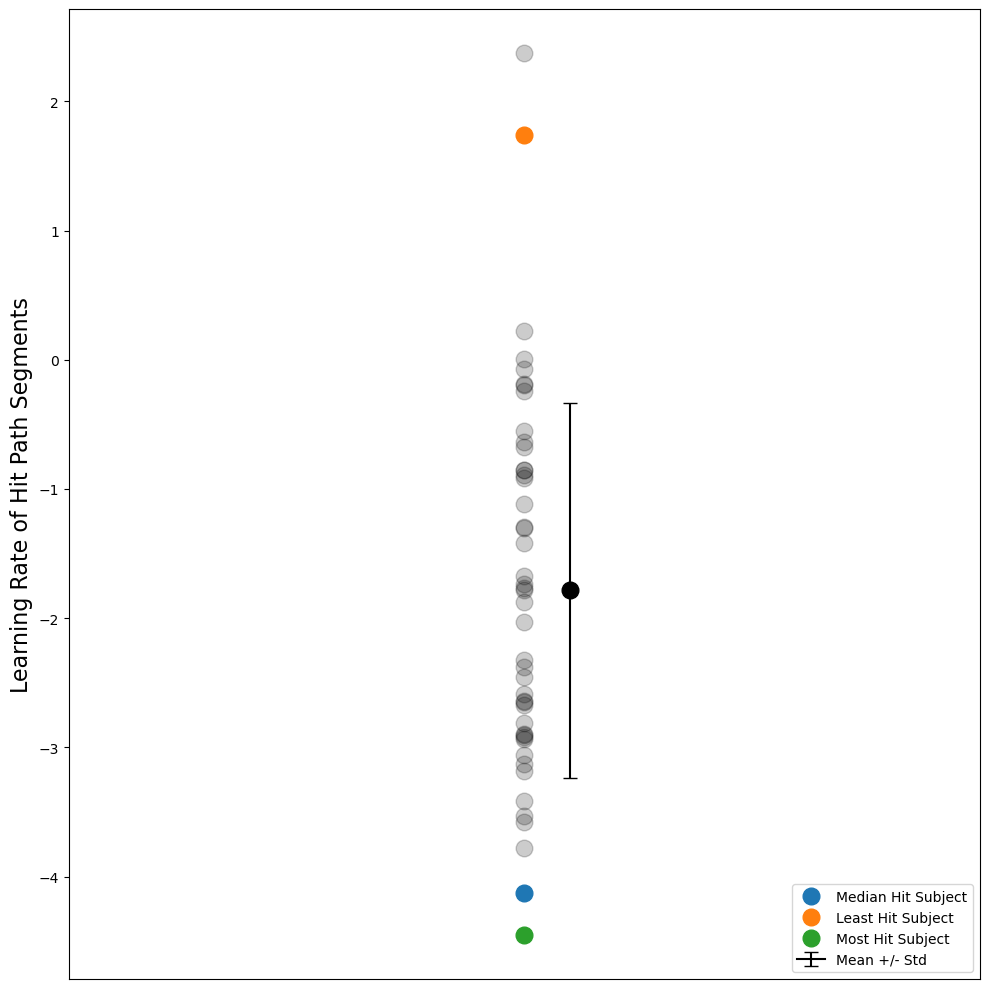

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for name, lr in list(segment_learning_rates.items()):
    if name == most_hit_subject:
        ax.plot(0, lr, "o", c='tab:green', zorder=100, label="Most Hit Subject", markersize=12)
    elif name == median_hit_subject:
        ax.plot(0, lr, "o", c='tab:blue', zorder=100, label="Median Hit Subject", markersize=12)
    elif name == least_hit_subject:
        ax.plot(0, lr, "o", c='tab:orange', zorder=100, label="Least Hit Subject", markersize=12)
    else:
        ax.plot(0,lr,'ko',alpha=0.2, markersize=12)
ax.set_ylabel("Learning Rate of Hit Path Segments", fontsize=16)
ax.set_xticks([])

lr_list = list(segment_learning_rates.values())
ax.plot(0.1, np.mean(lr_list), "ko", markersize=12)
ax.errorbar(0.1, np.mean(lr_list), yerr=np.std(lr_list), markersize=12, c="k", capsize=5, label="Mean +/- Std")
ax.set_xlim([-1,1])
ax.legend(loc="lower right")

fig.tight_layout()

In [27]:
fig.savefig(image_path / "analysis/segment_learning_rates.pdf", dpi=300, format="pdf")

1.316667 (934, 2) Hit 3.35 4.666667


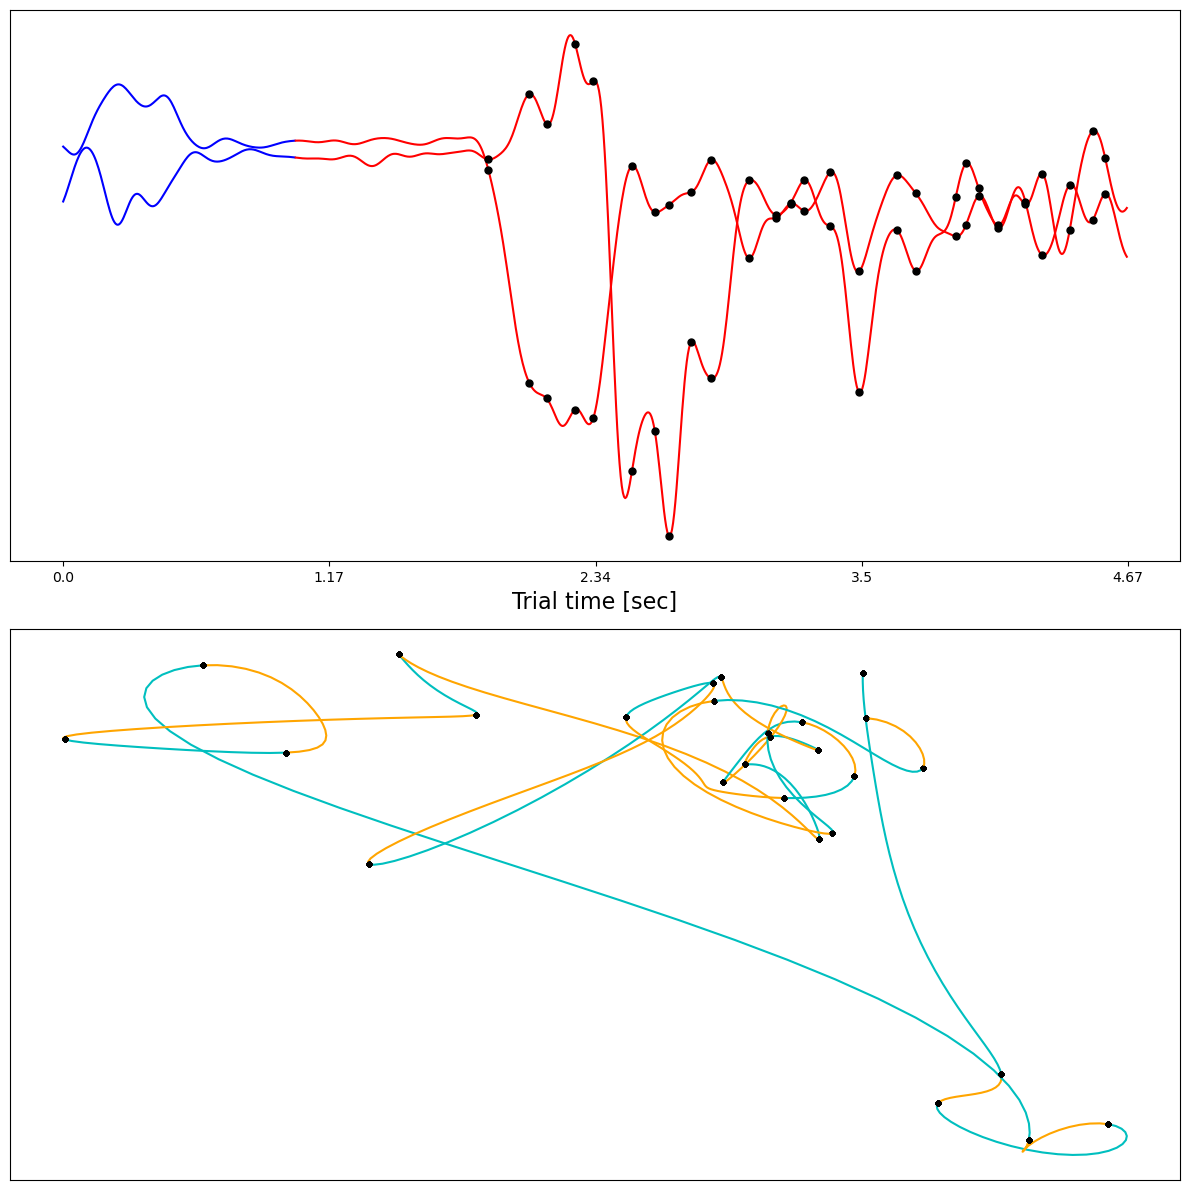

In [28]:
example_subject = 8
example_session = 8
example_trial_index = 8

s = c.alphabetically_sorted_subjects()[example_subject]
sesh = s.tasks["center_hold"].sorted_sessions()[example_session]
t = sesh.sorted_trials()[example_trial_index]
t.get_trajectory()
trajectory = t.trajectory[:,-2:]
# time at beginning of trial for holding
hold_steps = int(np.ceil(trial.hold_time*sample_rate)) + reaction_time_delay
# find segments
segment_indices = get_segment_indices(trajectory, hold_steps=hold_steps)

print(t.hold_time, trajectory.shape, t.outcome, t.reach_time, t.hold_time+t.reach_time)

fig, axes = plt.subplots(2,1, figsize=(12,12))

# test plot
axes[0].plot(range(hold_steps), trajectory[:hold_steps,0], "b", label = "Ignored hold section")
axes[0].plot(range(hold_steps, trajectory.shape[0]), trajectory[hold_steps:,0], "r", label="Segmented section")
axes[0].plot(range(hold_steps), trajectory[:hold_steps,1], "b")
axes[0].plot(range(hold_steps, trajectory.shape[0]), trajectory[hold_steps:,1], "r")
axes[0].plot(segment_indices, trajectory[segment_indices,0], "ko",markersize=5, label="Segment break")
axes[0].plot(segment_indices, trajectory[segment_indices,1], "ko",markersize=5)

axes[0].set_xlabel("Trial time [sec]")
num_ticks = 5
axes[0].set_xticks(ticks= np.linspace(0,trajectory.shape[0],num_ticks,endpoint=True), labels=np.round(np.linspace(0,trajectory.shape[0]/200,num_ticks,endpoint=True),2))
axes[0].set_yticks([])

color = "orange"
for i, zc in enumerate(segment_indices[:-1]):
    if color == "orange":
        color = "c"
    else:
        color = "orange"
    axes[1].plot(trajectory[zc:segment_indices[i+1]+1,0],trajectory[zc:segment_indices[i+1]+1,1], c=color)
    axes[1].plot(trajectory[segment_indices,0], trajectory[segment_indices,1], "ko", markersize=3)

axes[1].set_xticks([])
axes[1].set_yticks([])

fig.tight_layout()

In [29]:
fig.savefig(image_path / "analysis/example_path_segments.pdf", dpi=300, format="pdf")

## example decoder

Text(0.5, 0, 'Radial Decoder Channel ($y$)')

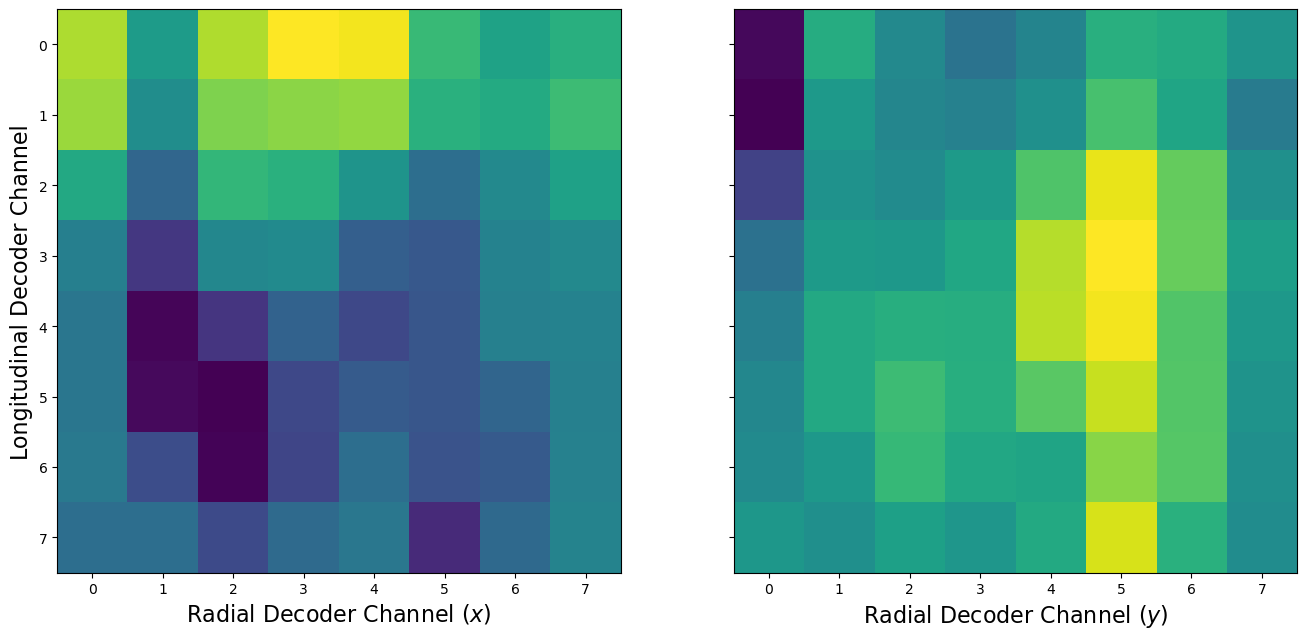

In [30]:
c = collection.Collection("emg_olympics")
# first alphabetical subject in the dict
s = c.subjects[c.subject_names[example_subject]]
decoder = s.decoder
decoder_heatmap_fig, axes = plt.subplots(1,2,figsize=[16,8],sharex=True, sharey=True)
axes[0].imshow(decoder[-2,:].reshape(8,8))
axes[0].set_xlabel("Radial Decoder Channel ($x$)", fontsize=16)
axes[0].set_ylabel("Longitudinal Decoder Channel", fontsize=16)
axes[1].imshow(decoder[-1,:].reshape(8,8))
axes[1].set_xlabel("Radial Decoder Channel ($y$)", fontsize=16)

In [31]:
decoder_heatmap_fig.savefig(image_path / "analysis/example_decoder.pdf", dpi=300, format="pdf")

## decoder correlation vs learning rates

In [32]:
def decoder_cosine(decoder):
    # cos = 1 - abs(dot(a,b) / (norm(a)*norm(b)))
    # orthogonal --> 90deg, dot=0 --> 1 
    # parallel --> 0deg, dot=1 --> 0
    x = decoder[-2,:]
    y = decoder[-1,:]
    return 1 - np.abs(np.dot(x,y) / (np.linalg.norm(x)*np.linalg.norm(y)))

In [33]:
decoder_cosines = {}
for sub in c.alphabetically_sorted_subjects():
    decoder_cosines[sub.name] = decoder_cosine(sub.decoder)

ordered_cosines = [decoder_cosines[sub.name] for sub in c.alphabetically_sorted_subjects()]

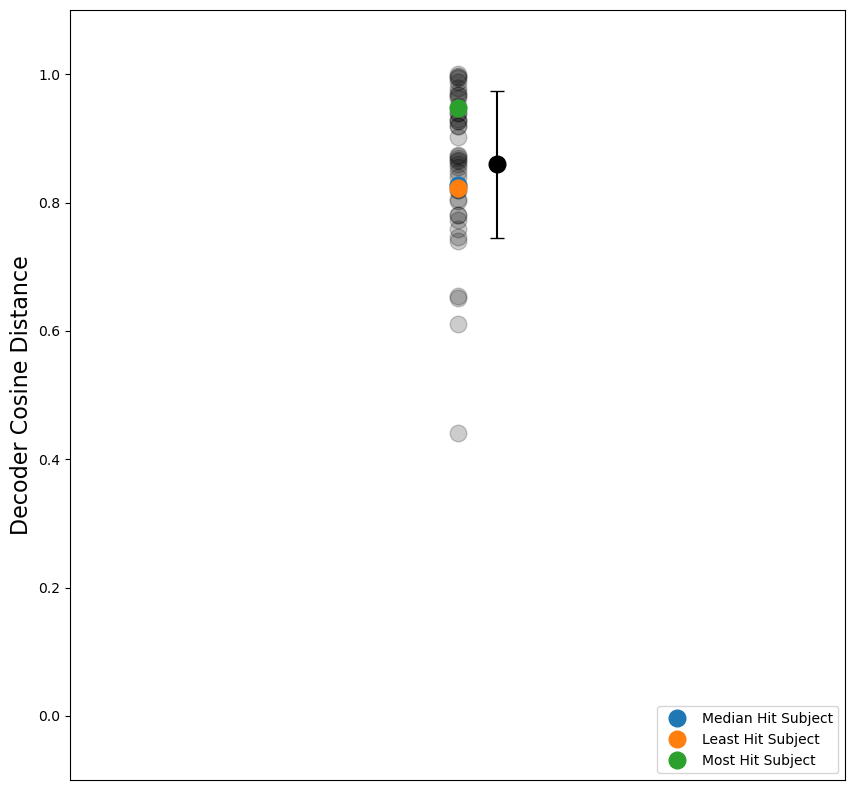

In [38]:
decoder_cosine_fig, ax = plt.subplots(1,1,figsize=(10,10))

for name, cs in list(decoder_cosines.items()):
    if name == most_hit_subject:
        ax.plot(0, cs, "o", c='tab:green', zorder=100, label="Most Hit Subject", markersize=12)
    elif name == median_hit_subject:
        ax.plot(0, cs, "o", c='tab:blue', zorder=100, label="Median Hit Subject", markersize=12)
    elif name == least_hit_subject:
        ax.plot(0, cs, "o", c='tab:orange', zorder=100, label="Least Hit Subject", markersize=12)
    else:
        ax.plot(0, cs, 'ko', alpha=0.2, markersize=12)

# ax.plot(0.1*np.ones(len(ordered_cosines)), ordered_cosines,'ko', markersize=12, alpha=0.2)
ax.errorbar(0.1, np.mean(ordered_cosines), np.std(ordered_cosines), color="k", capsize=5, markersize=12)
ax.plot(0.1, np.mean(ordered_cosines), "ko", markersize=12)
ax.set_xlim([-1,1])
ax.set_ylim([-0.1,1.1])
ax.set_xticks([])
ax.set_ylabel("Decoder Cosine Distance")
ax.legend(loc="lower right")

In [39]:
decoder_cosine_fig.savefig(image_path / "analysis/decoder_cosines.pdf", dpi=300, format="pdf")

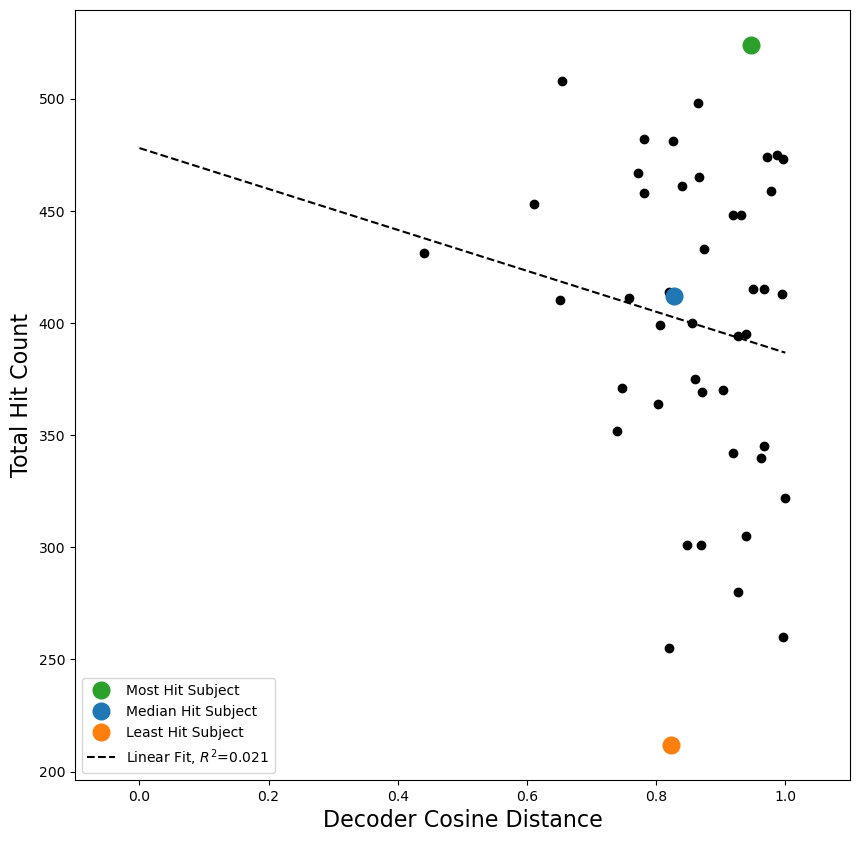

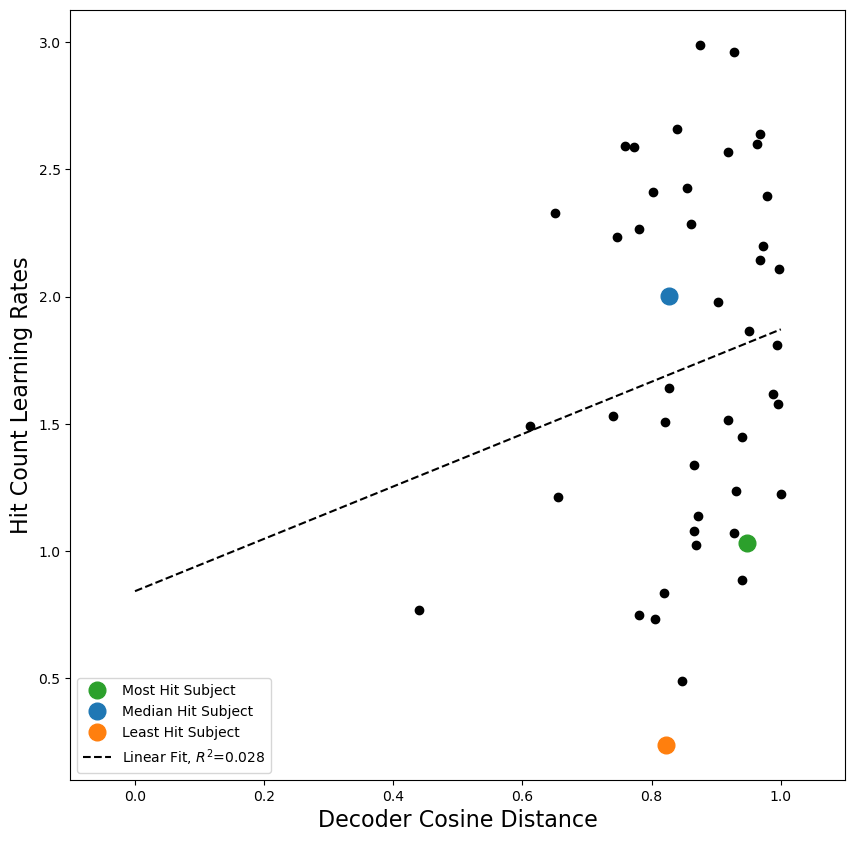

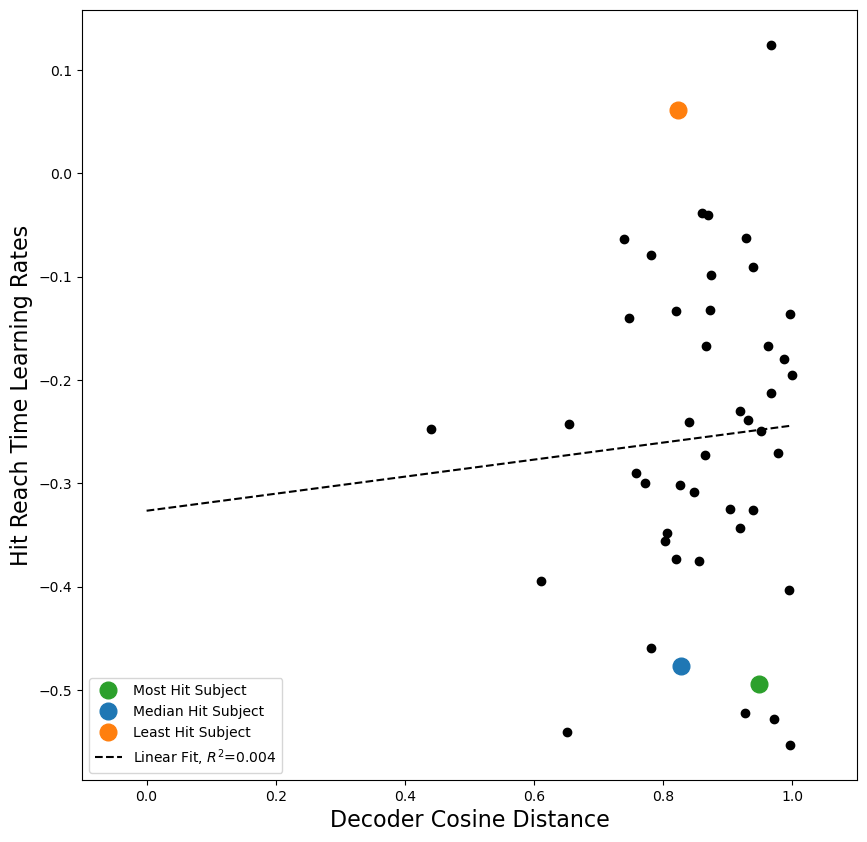

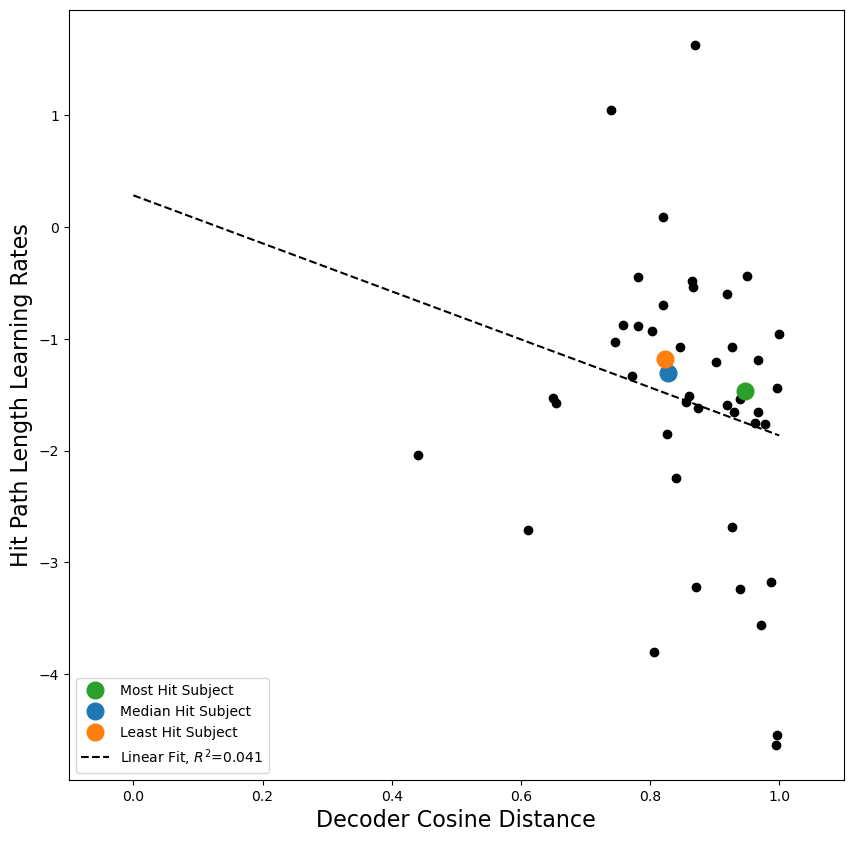

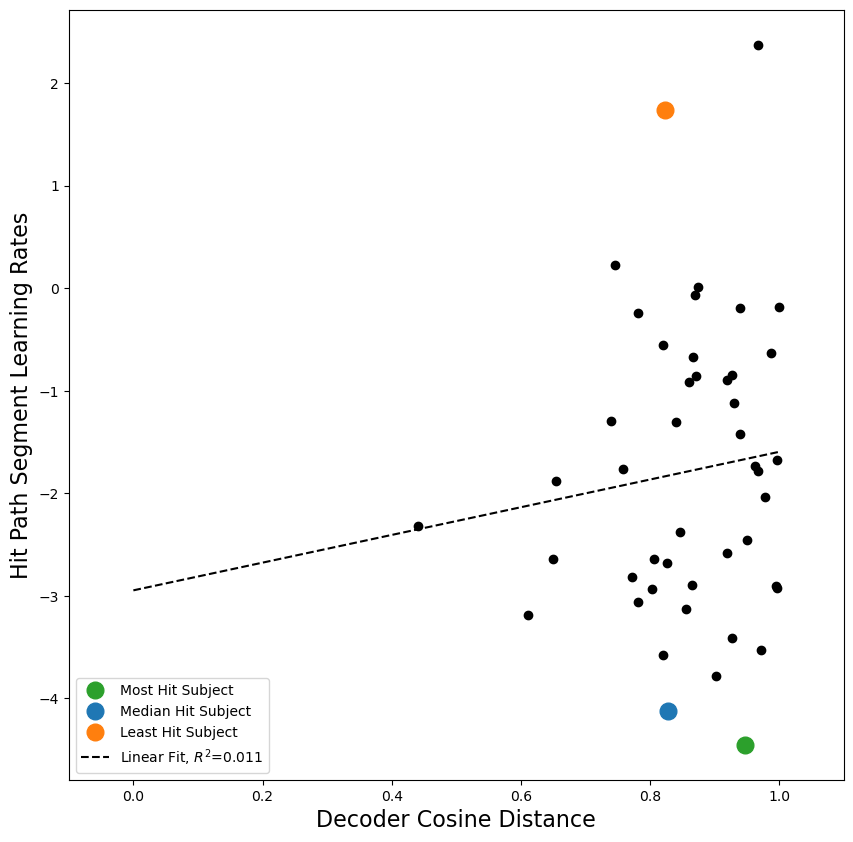

In [41]:
def lr_decoder_fig(lr, ylabel):
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ordered_learning_rates = []
    for sub in c.alphabetically_sorted_subjects():
        ordered_learning_rates.append(lr[sub.name])

    ax.plot(decoder_cosines[most_hit_subject], lr[most_hit_subject], "o", c='tab:green', zorder=100, label="Most Hit Subject", markersize=12)
    ax.plot(decoder_cosines[median_hit_subject], lr[median_hit_subject], "o", c='tab:blue', zorder=100, label="Median Hit Subject", markersize=12)
    ax.plot(decoder_cosines[least_hit_subject], lr[least_hit_subject], "o", c='tab:orange', zorder=100, label="Least Hit Subject", markersize=12)    

    # [-1,1] 1 is parallel, -1 is antiparallel, 0 is orthogonal
    ax.plot(ordered_cosines, ordered_learning_rates, 'ko')
    ax.set_xlabel("Decoder Cosine Distance")
    ax.set_ylabel(ylabel)
    from scipy.stats import linregress
    result = linregress(ordered_cosines, ordered_learning_rates)
    x = np.linspace(0,1,100)
    ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 3)}")
    ax.set_xlim([-0.1,1.1])
    xy = (0.7*ax.get_xlim()[1], 0.8*ax.get_ylim()[1])
    # ax.annotate(f"$R^2$ = {np.round(result.rvalue**2, 3)}", xy, fontsize=16)
    ax.legend(loc="lower left")

    return fig, ax

fig, ax = lr_decoder_fig(hit_sums, "Total Hit Count")
fig.savefig(image_path / "analysis/hit_count_decoder_cosine.pdf", dpi=300, format="pdf")

fig, ax = lr_decoder_fig(hit_learning_rates, "Hit Count Learning Rates")
fig.savefig(image_path / "analysis/hit_lr_decoder_cosine.pdf", dpi=300, format="pdf")

fig, ax = lr_decoder_fig(reach_time_learning_rates, "Hit Reach Time Learning Rates")
fig.savefig(image_path / "analysis/reach_time_lr_decoder_cosine.pdf", dpi=300, format="pdf")

fig, ax = lr_decoder_fig(path_length_learning_rates, "Hit Path Length Learning Rates")
fig.savefig(image_path / "analysis/path_length_lr_decoder_cosine.pdf", dpi=300, format="pdf")

fig, ax = lr_decoder_fig(segment_learning_rates, "Hit Path Segment Learning Rates")
fig.savefig(image_path / "analysis/segment_lr_decoder_cosine.pdf", dpi=300, format="pdf")